In [5]:
import sys
import PyQt5
from PyQt5 import QtGui
from PyQt5 import QtCore

from PyQt5.QtGui import * 
from PyQt5.QtWidgets import  QApplication, QWidget, QPushButton, QFileDialog, QVBoxLayout, QMessageBox, QLineEdit, QFormLayout,QLabel, QGridLayout, QCheckBox, QSlider
from PyQt5.QtCore import Qt, QTimer, QObject, QThread, pyqtSignal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
import scipy.stats as stats
import time
import datetime
from scipy import optimize
from scipy.interpolate import interp2d
import serial
import matplotlib
        


In [6]:


def AmpsToCurrent(val):
    ArduinoVal_12A=85
    return max(1,int(val*ArduinoVal_12A/12))

def GetVacuumReading(val):
    fitA=103.3079
    fitB=1027
    return 10**((val-fitB)/fitA)

In [7]:
class BeamGui:
    HardCurrentLimit=35
    HardCurrentStepLimit=30
    comdict={'current': 1,
             'serial_port' :'COM4',
             'baud_rate':  9600,
             'bufferpause':1.1,
             'delay':10}
    
    ShuttingDown=False
    StreamToGDrive=True
    
    recordtimes=[]
    currents=[]
    vacuums=[]
    
    CurrentNow = 1 
    def __init__(self):

            self.LastTimeString=datetime.datetime.now().strftime('%m_%d,%H_%M_%S')
            self.FirstTime=time.time()

            self.Outfile="./Data/"+self.LastTimeString+".dat"
            self.OutPlot="./Data/plot.png"
            # PyQt setup stuff
            self.app = QApplication([])
            self.window = QWidget()
            self.layout= QGridLayout()

            # Initiate all the GUI frames and make the layout
            #self.SetupCameraThread()
            self.SetupActionsFrame()
            self.SetupFigFrame()
            self.SetupMonitoringFrame()
            self.SetupArduinoThread()
            
            self.TimeOfLastStep=time.time()
            self.TimeOfLastStepDown=time.time()
            
            self.layout.addLayout(self.MonitorLayout,1,0)
            self.layout.addLayout(self.ActionsLayout,3,0)


            self.layout.addLayout(self.FigLayout,1,2,3,1)
            


            #lets go!
            self.window.setLayout(self.layout)
            self.window.show()
            self.app.exec()


    def SetupFigFrame(self):
            self.FigLayout=QVBoxLayout()
            self.fig2= plt.figure(figsize=(5,5),dpi=150)
            #self.fig2.add_axes(rect=[0.1,0,1,1])

            gs = self.fig2.add_gridspec(2, hspace=0)
            gs.update(left=0.2)
            self.ax2 = gs.subplots(sharex=True, sharey=False)

            self.CanvasObj2=FigureCanvasQTAgg(self.fig2)
            #self.MakePosPlots()

            #self.CanvasObj.mpl_connect("button_release_event", self.on_map_press)

            #self.CanvasObj2.mpl_connect("button_press_event", self.on_zplot_press)
            #self.CanvasObj2.mpl_connect("button_release_event", self.on_zplot_release)

            self.FigLayout.addWidget(self.CanvasObj2)
            
    def SetupActionsFrame(self):
            self.ActionsLayout= QGridLayout()

            self.SetCurrent=QPushButton('Set')
            self.SetCurrent.clicked.connect(self.on_setcurrent_click)
            self.CurrentVal=QLineEdit(text=str(1))



            self.Climbing=QCheckBox("Climb current?",checked=False)

            self.CurrentMax=QLineEdit(text=str(21))
            self.ClimbBy=QLineEdit(text=str(1))
            self.TryEvery=QLineEdit(text=str(300))
            self.VacStepThresh=QLineEdit(text=str(2e-5))


            self.LimVac=QCheckBox("Limit Vacuum?",checked=False)

            self.Limit=QLineEdit(text=str(8e-5))
            self.Backoff=QLineEdit(text=str(1))

            self.AutoShut=QCheckBox("Auto Shutoff?",checked=True)
            self.ShutCurrent=QLineEdit(text=str(21))
            self.ShutVacuum=QLineEdit(text=str('3e-06'))
            
            

            self.ActionsLayout.addWidget(QLabel("Set current to:"),1,0,1,3)

            self.ActionsLayout.addWidget(self.CurrentVal,2,0,1,2)
            self.ActionsLayout.addWidget(self.SetCurrent,2,2,1,2)


#            self.ActionsLayout.addWidget(QLabel("Limit vaccum:"),3,0,1,3)
            
           #  self.ActionsLayout.addWidget(QLabel("  Limit vacuum"),4,0,1,1)
            self.ActionsLayout.addWidget(QLabel("  Max"),4,1,1,1)
            self.ActionsLayout.addWidget(QLabel("  Step back by"),4,2,1,1)

            self.ActionsLayout.addWidget(self.LimVac,5,0,1,1)
            self.ActionsLayout.addWidget(self.Limit,5,1,1,1)
            self.ActionsLayout.addWidget(self.Backoff,5,2,1,1)


#            self.ActionsLayout.addWidget(QLabel("Climb Function:"),6,0,1,3)
 
            self.ActionsLayout.addWidget(self.Climbing,9,0,1,3)  
            self.ActionsLayout.addWidget(QLabel("  Step each (s)"),8,1,1,1)
            self.ActionsLayout.addWidget(QLabel("  by (A)"),8,2,1,1)
            self.ActionsLayout.addWidget(self.TryEvery,9,1,1,1)
            self.ActionsLayout.addWidget(self.ClimbBy,9,2,1,1)
            self.ActionsLayout.addWidget(QLabel("  up to (A)"),10,1,1,1)
            self.ActionsLayout.addWidget(QLabel("  when below (Torr)"),10,2,1,1)
            self.ActionsLayout.addWidget(self.CurrentMax,11,1,1,1)  
            self.ActionsLayout.addWidget(self.VacStepThresh,11,2,1,1)  
            
            self.ActionsLayout.addWidget(QLabel("  Current (A)"),12,1,1,1)
            self.ActionsLayout.addWidget(QLabel("  Vacuum (Torr)"),12,2,1,1)
            self.ActionsLayout.addWidget(self.AutoShut,14,0,1,3)  
            self.ActionsLayout.addWidget(self.ShutCurrent,14,1,1,3)  
            self.ActionsLayout.addWidget(self.ShutVacuum,14,2,1,3)  

            
            
    def SetupMonitoringFrame(self):
            self.MonitorLayout= QGridLayout()

            self.VacuumQuality=QLineEdit(text=str(5e-5)+"Torr")
            self.VacuumQuality.setFont(QFont('Courier', 20,700))  
            
            self.VacuumQuality.setStyleSheet(
                """QLineEdit { background-color: darkGreen; color: white }""")
            self.VacuumQuality.setAlignment(QtCore.Qt.AlignCenter) 
            
            self.Current=QLineEdit(text="11 A")
            self.Current.setFont(QFont('Courier', 20,700))    
            self.Current.setStyleSheet(
                """QLineEdit { background-color: darkGreen; color: white }""")
            self.Current.setAlignment(QtCore.Qt.AlignCenter) 

            self.LastUpdate=QLabel("Last update: "+str(self.LastTimeString))
            
            self.MonitorLayout.addWidget(QLabel("Set current:"),1,0,1,3)
            self.MonitorLayout.addWidget(self.Current,2,0,1,3)

            self.MonitorLayout.addWidget(QLabel("Vacuum:"),4,0,1,3)
            self.MonitorLayout.addWidget(self.VacuumQuality,5,0,1,3)

            self.MonitorLayout.addWidget(self.LastUpdate,7,0,1,3)

            
    # This starts the thread running for the camera acquisitions
    def SetupArduinoThread(self):
        self.thread = QThread()
        self.worker=DataStream(self.comdict)
        self.worker.moveToThread(self.thread)
        self.thread.started.connect(self.worker.run)
        self.worker.vacuumdat.connect(self.UpdateData)
        self.thread.start()            


    def UpdateData(self,data):
        self.VacuumNow=data
        self.VacuumQuality.setText(str('%.2E' % self.VacuumNow)+str(' Torr'))

        self.Current.setText(str('%.2F' % self.CurrentNow)+str(' A'))

        self.LastTimeString=datetime.datetime.now().strftime('%m/%d, %H:%M:%S')
        self.LastUpdate.setText("Last update: "+str(self.LastTimeString))

        if(self.LimVac.isChecked()==True):
            if(len(self.vacuums)>3):
                if(np.max(self.vacuums[-3:])>float(self.Limit.text())):
                    if((time.time()-self.TimeOfLastStepDown)>float(self.TryEvery.text())):
                        self.CurrentVal.setText(str(max(float(self.CurrentVal.text())-float(self.Backoff.text()),0)))
                        self.TimeOfLastDown=time.time()
                        self.on_setcurrent_click()

        if(self.Climbing.isChecked()==True):
            if((time.time()-self.TimeOfLastStep)>float(self.TryEvery.text())):
                #print("Its time")
                
                # Check vacuum. The seocnd clause makes sure its not a faulty gauge readying
                if(self.VacuumNow<float(self.VacStepThresh.text()) and (self.VacuumNow>1e-7)):
                    #print("Vac is ok")
                    if(self.CurrentNow< min(float(self.CurrentMax.text()),self.HardCurrentLimit)):
                        #print("Stepping current")
                        self.CurrentVal.setText(str(self.CurrentNow+min(float(self.ClimbBy.text()),self.HardCurrentStepLimit)))
                        self.on_setcurrent_click()

                #else:
                    #print("not raising I, vacuum check failed")
                    
        if(self.AutoShut.isChecked()==True):
            if((self.CurrentNow>=float(self.ShutCurrent.text())) or  self.ShuttingDown==True):
                if(self.VacuumNow<=float(self.ShutVacuum.text())):
                    self.ShuttingDown=True
                    if((time.time()-self.TimeOfLastStepDown)>float(self.TryEvery.text())):
                        self.Climbing.setChecked(False)
                        self.LimVac.setChecked(False)
                        self.CurrentVal.setText(max(float(self.CurrentVal.text())-1,0))
                        self.on_setcurrent_click()
                        self.TimeOfLastStepDown=time.time()

        self.recordtimes.append(time.time()-self.FirstTime)
        self.vacuums.append(self.VacuumNow)
        self.currents.append(self.CurrentNow)
        if(self.StreamToGDrive):
            with open(self.Outfile, "a") as myfile:
                myfile.write(str(self.recordtimes[-1])+","+str(self.vacuums[-1])+","+str(self.currents[-1])+"\n")
        
        self.ax2[0].clear()
        self.ax2[1].clear()
        self.ax2[1].semilogy()
        self.ax2[0].plot(self.recordtimes,self.currents,color='DarkRed')
        self.ax2[0].set_xlabel("time")
        self.ax2[0].set_ylabel("I [ A ]")
        self.ax2[1].plot(self.recordtimes,self.vacuums,color='DarkBlue')
        self.ax2[1].set_xlabel("time")
        self.ax2[1].set_ylabel("Vac [ Torr ]")
        self.ax2[1].set_ylim(1e-6,2e-4)
        self.ax2[1].tick_params(axis='y', which='both', labelsize=8,rotation=45)
        self.ax2[0].set_title("Last update: "+str(self.LastTimeString))
        self.CanvasObj2.draw()

        plt.savefig(self.OutPlot,dpi=200,bbox_inches='tight')
        

        
        
    def on_photo_press(self):
        self.ShuttingDown=False

        return(True)
    
    def on_setcurrent_click(self):
        self.CurrentNow=float(min(float(self.CurrentVal.text()),self.HardCurrentLimit))
        self.Current.setText('%.2F' % self.CurrentNow + str(" A"))
        self.comdict['current']=self.CurrentNow
        self.TimeOfLastStep=time.time()
        return(True)
        

    

        
class DataStream(QObject):


    vacuumdat=pyqtSignal(float)
    finished=pyqtSignal()

    def __init__(self,comdict):
        super().__init__()
        self.vacuumlevel=1e-5
        self.comdict=comdict
        self.ser = serial.Serial(self.comdict['serial_port'],self.comdict['baud_rate'])
                                                           
    def run(self):
        while(True):
            #self.vacuumlevel=self.vacuumlevel*1.02
            #print("Sending current "+str(AmpsToCurrent(self.comdict['current'])))
            self.ser.reset_output_buffer()
            self.ser.reset_input_buffer()
            time.sleep(self.comdict['bufferpause'])
            line = self.ser.readline().decode('utf-8').strip()
            try:
                # print("raw: "+str(line))
                self.vacuumlevel = GetVacuumReading(int(line))
                #print(f"Read Analog Value: {self.vacuumlevel}")
                self.vacuumdat.emit(self.vacuumlevel)

                # Get the analog voltage from the user
                #voltage_value = voltage_value+5

                # Send the analog voltage value to the Arduino
                self.ser.write(f"{AmpsToCurrent(self.comdict['current'])}\n".encode())

                # Add a delay (optional)
                #print(str(AmpsToCurrent(self.comdict['current']))+","+str(self.vacuumlevel))
            except:
                print("something didn't work right... trying again")
            time.sleep(self.comdict['delay']-self.comdict['bufferpause'])


something didn't work right... trying again
something didn't work right... trying again
something didn't work right... trying again
something didn't work right... trying again
something didn't work right... trying again
something didn't work right... trying again
something didn't work right... trying again
something didn't work right... trying again
something didn't work right... trying again


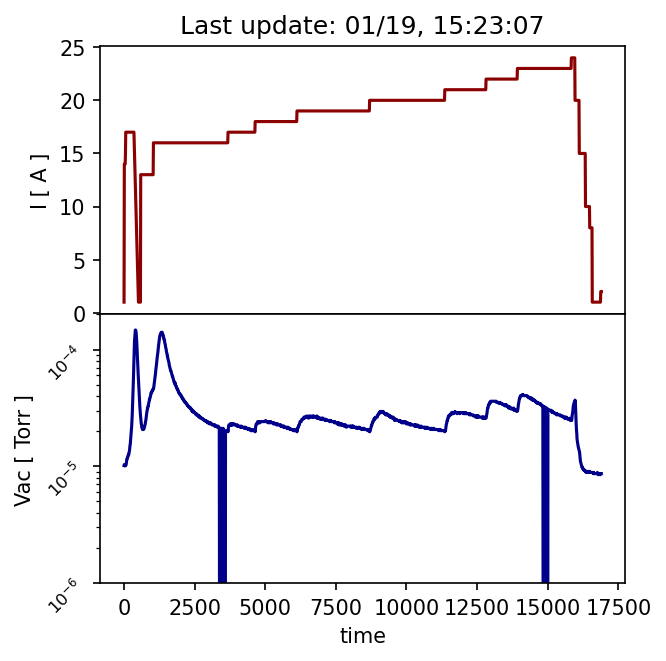

In [8]:
BeamGui()